# pyLocalGLMnet - Eine Python Implementierung des Richman/Wüthrich Ansatzes

# Inhalt 
[__1. Einleitung__](#1-bullet) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[1.1 Dependencies](#1_1-bullet) <br>
<br>

[__2. Datensatz 1: Künstlicher Datensatz__](#2-bullet) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[2.1 Künstlichen Datensatz erzeugen](#2_1-bullet) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[2.2 LocalGLMnet](#2_2-bullet) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.2.1 GLM](#2_2_1-bullet) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.2.2 LocalGLMnet](#2_2_2-bullet) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.2.3 Performance Benchmark](#2_2_3-bullet) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[2.3 Auswertung](#2_3-bullet) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3.1 Variable Selection](#2_4-bullet) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3.2 Feature Contribution](#2_5-bullet) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3.3 Interaction Strengths](#2_6-bullet) <br>
<br>

[__3. Datensatz 2: freMTPL2freq__](#3-bullet)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[3.1 Preprocessing](#3_1-bullet) <br>
<br>

[__4. Zusammenfassung und Fazit__](#4-bullet)<br>

<hr>

# 1. Einleitung <a class="anchor" id="1-bullet"></a>

<hr>

Text

## 1.1 Dependencies <a class="anchor" id="1_1-bullet"></a>

In [33]:
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras import initializers
import tensorflow as tf
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches
from scipy import interpolate
import scipy.stats as stats

<hr>

# 2. Datensatz 1: Künstlicher Datensatz <a class="anchor" id="2-bullet"></a>

<hr>

## 2.1 Künstlichen Datensatz erzeugen <a class="anchor" id="2_1-bullet"></a>

In [2]:
def target_variable(x):
    return (1/2)*x[0] - (1/4)*(x[1]**2) + (1/2)*abs(x[2])*math.sin(2*x[2]) + (1/2)*x[3]*x[4] + (1/8)*(x[4]**2)*x[5]

In [3]:
# Random Number Generator
rng = np.random.default_rng(seed=10)

# Trainingsdatensatz
## Generate Training Data x1, x3, x4, x5, x6, x7
x1_train = rng.standard_normal(size=(100000,1))
x3_7_train = rng.standard_normal(size=(100000, 5))

## Variablen x2, x8 mit 50 % Korrelation
cov_matrix = [[1, 0.5], [0.5, 1]]
x2_x8_train = rng.multivariate_normal(mean=[0, 0], cov=cov_matrix, size=100000)

# Zusammenfügen und Zielvariable berechnen
x_train = np.column_stack(
    (x1_train, x2_x8_train[:, 0], x3_7_train, x2_x8_train[:, 1]))
y_train = np.array(list(map(target_variable, x_train[:, 0:7])))


In [4]:
# Testdatensatz
## Generate Training Data x1, x3, x4, x5, x6, x7
x1_test = rng.standard_normal(size=(100000, 1))
x3_7_test = rng.standard_normal(size=(100000, 5))

## Variablen x2, x8 mit 50 % Korrelation
x2_x8_test = rng.multivariate_normal(mean=[0, 0], cov=cov_matrix, size=100000)

# Zusammenfügen und Zielvariable berechnen
x_test = np.column_stack(
    (x1_test, x2_x8_test[:, 0], x3_7_test, x2_x8_test[:, 1]))
y_test = np.array(list(map(target_variable, x_test[:, 0:7])))

In [5]:
# Check, if x2 and x8 are correlated
np.cov(x_train[:,1],x_train[:,7])

array([[1.00337485, 0.50257051],
       [0.50257051, 1.00118904]])

## 2.2 LocalGLMnet <a class="anchor" id="2_2-bullet"></a>

### 2.2.1 GLM <a class="anchor" id="2_2_1-bullet"></a>

In [8]:
import statsmodels.api as sm
local_glm_net = sm.OLS(y_train,x_train)
results = local_glm_net.fit()

In [32]:
init_weights = np.array(results.params)
for i in range(init_weights.size):
    print("β"+str(i)+": "+str(init_weights[i]))

β0: 0.4978484272324386
β1: -0.0004891846725070491
β2: 0.024869851792013703
β3: 0.0023907447471462253
β4: -0.00036490188205334925
β5: 0.1287993578532571
β6: -0.0006273017117452849
β7: 0.0005456536929258455


In [10]:
init_weights

array([ 4.97848427e-01, -4.89184673e-04,  2.48698518e-02,  2.39074475e-03,
       -3.64901882e-04,  1.28799358e-01, -6.27301712e-04,  5.45653693e-04])

### 2.2.2 LocalGLMnet <a class="anchor" id="2_2_2-bullet"></a>

In [12]:
tf.random.set_seed(10)

In [13]:
input = keras.Input(shape=(8), dtype= "float32")

In [14]:
attention = input

attention = keras.layers.Dense(units=20, activation="tanh")(attention)
attention = keras.layers.Dense(units=15, activation="tanh" )(attention)
attention = keras.layers.Dense(units=10, activation="tanh")(attention)
attention = keras.layers.Dense(units=8, activation="linear", name="Attention")(attention)

2023-02-10 15:34:04.649506: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
response = keras.layers.Dot(axes=1)([input, attention])
response = keras.layers.Dense(units=1, activation="linear", name="Response")(response) 
# Wofür Dense Schicht notwendig? Ggf. um einen letzten Bias in die Funktion einzufügen
# Wenn es bspw. 8 Inputvariablen gibt und das Modell vorher die Koeffizienten a1-a8 lernt kann das Modell so zusätzlich den Intercept a0 erlernen
# Dot Layer implementiert also die eigentliche Skip Connection --> Skalarprodukt multipliziert jeweils die Einträge mit dem selben Index verschiedener Ebenen und addiert diese
# Da im Skalarprodukt der Einfluss jeder Variable enthalten ist muss um Aussage über die Feature Contribution einzelner Werte machen zu könnnen die partielle Ableitung 
# nach der entsprechenden Variable genommen werden

In [16]:
local_glm_net = keras.Model(inputs=input, outputs=response)
local_glm_net.compile(loss="mse", optimizer="nadam")

In [17]:
local_glm_net.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 20)           180         input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 15)           315         dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 10)           160         dense_1[0][0]                    
______________________________________________________________________________________________

In [18]:
history = local_glm_net.fit(x_train, y_train,
          batch_size=32, epochs=10, validation_split = 0.2)

2023-02-10 15:34:05.032055: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
2500/2500 [==============================] - 5s 2ms/step - loss: 0.1680 - val_loss: 0.0637
Epoch 2/10
2500/2500 [==============================] - 3s 1ms/step - loss: 0.0454 - val_loss: 0.0368
Epoch 3/10
2500/2500 [==============================] - 4s 2ms/step - loss: 0.0328 - val_loss: 0.0305
Epoch 4/10
2500/2500 [==============================] - 3s 1ms/step - loss: 0.0257 - val_loss: 0.0215
Epoch 5/10
2500/2500 [==============================] - 3s 1ms/step - loss: 0.0154 - val_loss: 0.0115
Epoch 6/10
2500/2500 [==============================] - 3s 1ms/step - loss: 0.0075 - val_loss: 0.0053
Epoch 7/10
2500/2500 [==============================] - 3s 1ms/step - loss: 0.0047 - val_loss: 0.0036
Epoch 8/10
2500/2500 [==============================] - 4s 1ms/step - loss: 0.0039 - val_loss: 0.0029
Epoch 9/10
2500/2500 [==============================] - 3s 1ms/step - loss: 0.0036 - val_loss: 0.0031
Epoch 10/10
2500/2500 [==============================] - 4s 2ms/step - loss: 0.003

### 2.2.3 Performance Vergleich <a class="anchor" id="2_2_3-bullet"></a>

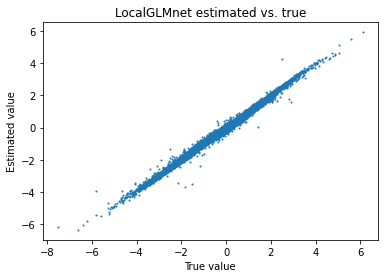

In [19]:
pred = local_glm_net.predict(x_test)

plt.scatter(y_test, pred, s= 1)
plt.xlabel("True value")
plt.ylabel("Estimated value")
plt.title("LocalGLMnet estimated vs. true")
plt.show()

## 2.3 Auswertung <a class="anchor" id="2_3-bullet"></a>

### 2.3.1 Variable Selection <a class="anchor" id="2_3_1-bullet"></a>

In [20]:
# Über die Methode get_weights() erhält man die Kantengewichte, sowie den Bias für jeder Schicht
# --> man erhält also eine Liste mit numpy Arrays die in der Länge der Anzahl der Ebenen * 2
weights = local_glm_net.get_weights()
for i in weights:
    print(i.shape, end= " | ")

(8, 20) | (20,) | (20, 15) | (15,) | (15, 10) | (10,) | (10, 8) | (8,) | (1, 1) | (1,) | 

In [21]:
local_glm_net.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 20)           180         input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 15)           315         dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 10)           160         dense_1[0][0]                    
______________________________________________________________________________________________

In [22]:
# Neues Model ohne Response-Schicht --> auslesen der Attention Schicht
weights_local_glm = keras.Model(
    inputs=local_glm_net.input, 
    outputs=local_glm_net.get_layer(name="Attention").output)

# Gewichte bestimmen
beta_x = weights_local_glm.predict(x_test)

In [23]:
# Skalierung der Attention mithilfe der Gewichte der Response Schicht (!= der tatsächlichen Vorhersage (--> beta_x liefert 8 Outputwerte, Response nur 1 Output))
beta_x_scaled = beta_x * weights[8]

# our architecture still requires a scaling coming from dense layer ’Response’ which 
# we add to have intercept beta_0 in our LocalGLMnet architecture 
# beta.x <- beta.x * as.numeric(get_weights(local_glm_net)[[9]])

# Ggf. in die Skalierung letzten Bias mit aufnehmen?
# --> beta_x = beta_x * local_glm_net.get_weights()[8] + local_glm_net.get_weights()[9]


In [24]:
# Merkmal 7 ist von der wahren Regressionsfunktion unabhängig --> Einsatz zur Berechnung des Konfidenzintervals
print("Mittelwert β7: " + str(beta_x_scaled[:,6].mean()))
print("Standardabweichung β7: " + str(beta_x_scaled[:,6].std()))

Mittelwert β7: -0.0030089694
Standardabweichung β7: 0.014167937


In [25]:
# Intervalgrenzen bestimmen
normal = np.random.standard_normal(10000)
alpha = 0.001
bound = stats.norm.ppf(alpha/2) * beta_x_scaled[:,6].std()

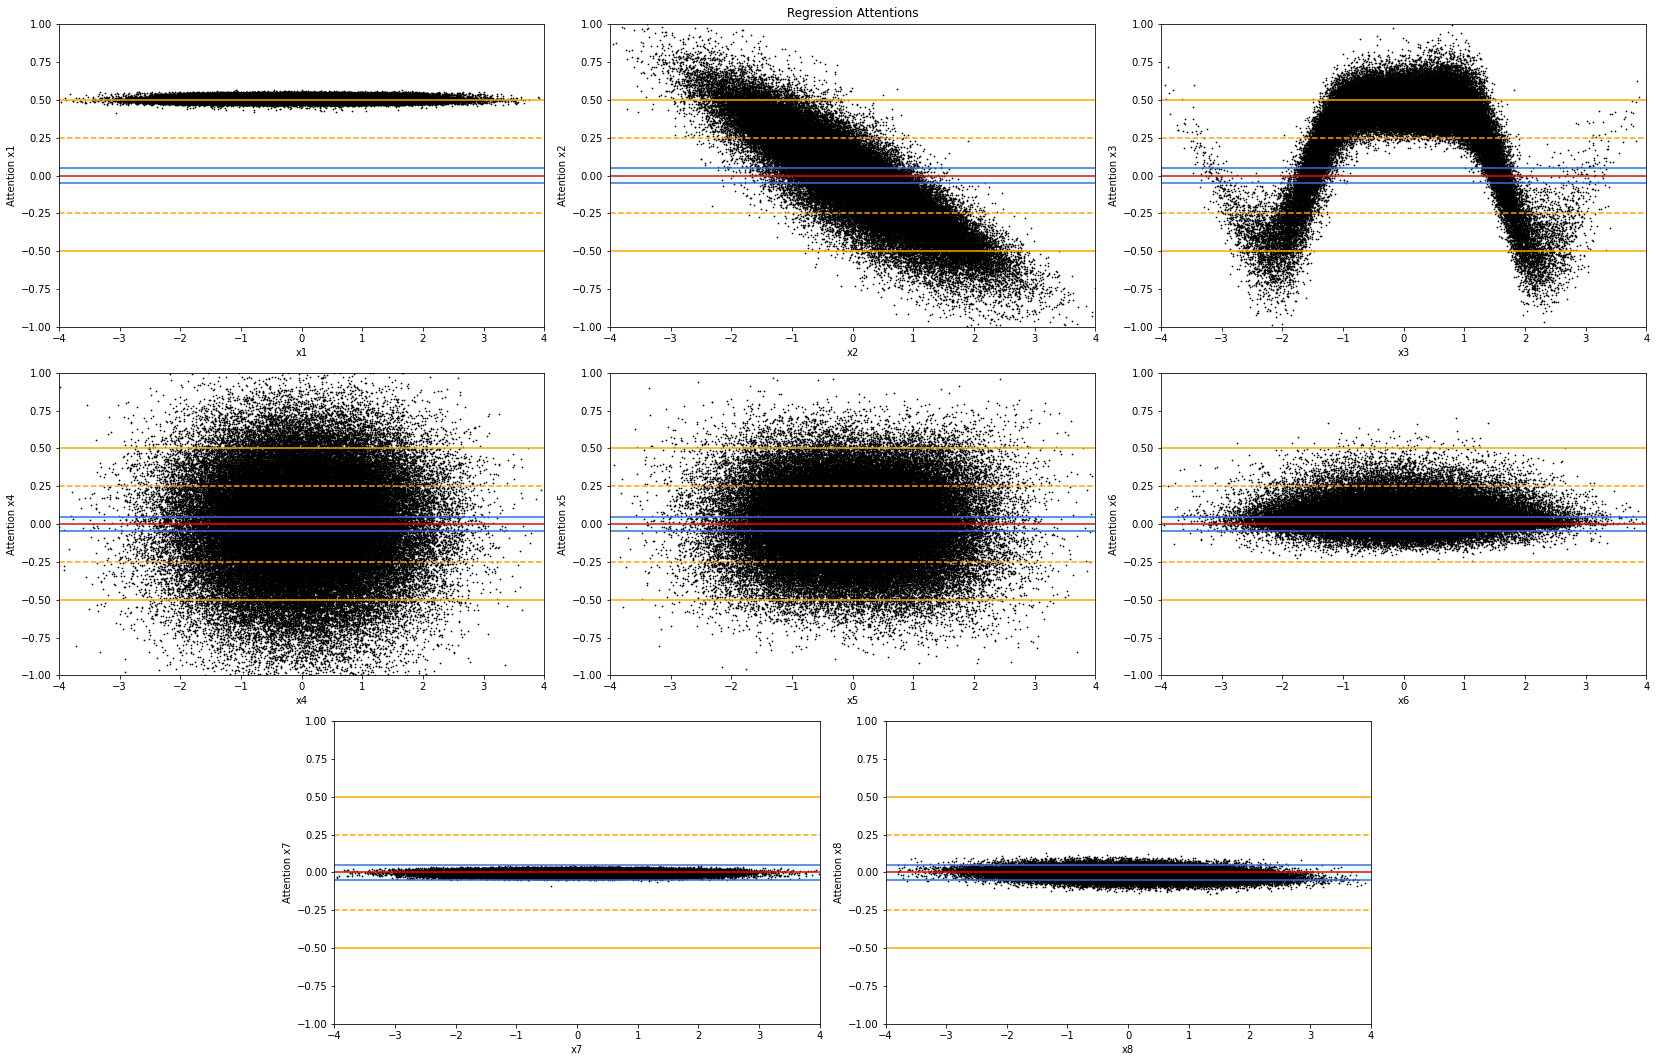

In [51]:
fig_attention = plt.figure(tight_layout=True, figsize=(30,15))

spec = GridSpec(ncols=8, nrows=3, figure=fig_attention)
ax1_att = fig_attention.add_subplot(spec[0, 1:3])
ax2_att = fig_attention.add_subplot(spec[0, 3:5])
ax3_att = fig_attention.add_subplot(spec[0, 5:7])
ax4_att = fig_attention.add_subplot(spec[1, 1:3])
ax5_att = fig_attention.add_subplot(spec[1, 3:5])
ax6_att = fig_attention.add_subplot(spec[1, 5:7])
ax7_att = fig_attention.add_subplot(spec[2, 2:4])
ax8_att = fig_attention.add_subplot(spec[2, 4:6])
axs_att = [ax1_att, ax2_att, ax3_att, ax4_att, ax5_att, ax6_att, ax7_att, ax8_att]

for i in range(len(axs_att)):
   
    axs_att[i].hlines(y=0.5,xmin=-4,xmax=4, colors="orange")
    axs_att[i].hlines(y=-0.5,xmin=-4,xmax=4, colors="orange")

    axs_att[i].hlines(y=0.25,xmin=-4,xmax=4, colors="orange",linestyles = "dashed")
    axs_att[i].hlines(y=-0.25,xmin=-4,xmax=4, colors="orange",linestyles = "dashed")

    axs_att[i].hlines(y=0,xmin=-4,xmax=4, colors="red")

    interval = patches.Rectangle(xy = (-4, bound), height = 2* abs(bound), width = 8, edgecolor='None', facecolor='lightcyan', alpha = 0.8, zorder = 1)
    axs_att[i].hlines(y=bound,xmin=-4,xmax=4, colors="royalblue")
    axs_att[i].hlines(y=-bound,xmin=-4,xmax=4, colors="royalblue")
    axs_att[i].add_patch(interval)
    axs_att[i].scatter(x_test[:, i],
                     beta_x_scaled[:, i], s=0.5, c="black")
    
    axs_att[i].set_xlim((-4, 4))
    axs_att[i].set_ylim((-1, 1))
    axs_att[i].set_xlabel("x"+str(i+1))
    axs_att[i].set_ylabel("Attention x"+str(i+1))

fig_attention.suptitle("Regression Attentions")
plt.show()

#### Hypothesentest

In [27]:
for i in range(8):
   if(i!=6):
      size = beta_x_scaled.shape[0]
      coverage = np.count_nonzero(beta_x_scaled[:,i] < abs(bound)) - np.count_nonzero(beta_x_scaled[:,i] < -abs(bound))
      coverage_ratio = coverage/size
      print("Coverage Ratio β"+str(i+1)+": "+str(coverage_ratio))
      if (coverage_ratio < 1-alpha):
         print("Nullhypothese verwerfen --> x"+str(i+1)+" darf nicht entfernt werden \n")
      else:
         print("Nullhypothese darf nicht verworfen werden --> x"+str(i+1)+" sollte entfernt werden \n")

Coverage Ratio β1: 0.0
Nullhypothese verwerfen --> x1 darf nicht entfernt werden 

Coverage Ratio β2: 0.13429
Nullhypothese verwerfen --> x2 darf nicht entfernt werden 

Coverage Ratio β3: 0.02193
Nullhypothese verwerfen --> x3 darf nicht entfernt werden 

Coverage Ratio β4: 0.11431
Nullhypothese verwerfen --> x4 darf nicht entfernt werden 

Coverage Ratio β5: 0.15153
Nullhypothese verwerfen --> x5 darf nicht entfernt werden 

Coverage Ratio β6: 0.58437
Nullhypothese verwerfen --> x6 darf nicht entfernt werden 

Coverage Ratio β8: 0.88821
Nullhypothese verwerfen --> x8 darf nicht entfernt werden 



### 2.3.2 Feature Contribution <a class="anchor" id="2_3_2-bullet"></a>

In [70]:
contribution = np.column_stack([x_test[:, i], beta_x_scaled[:, i]*x_test[:, i]])
con_ind = np.lexsort((contribution[:,1], contribution[:,0]))
contribution_sorted = contribution[con_ind]
con_spline = interpolate.UnivariateSpline(contribution_sorted[:,0], contribution_sorted[:,1])

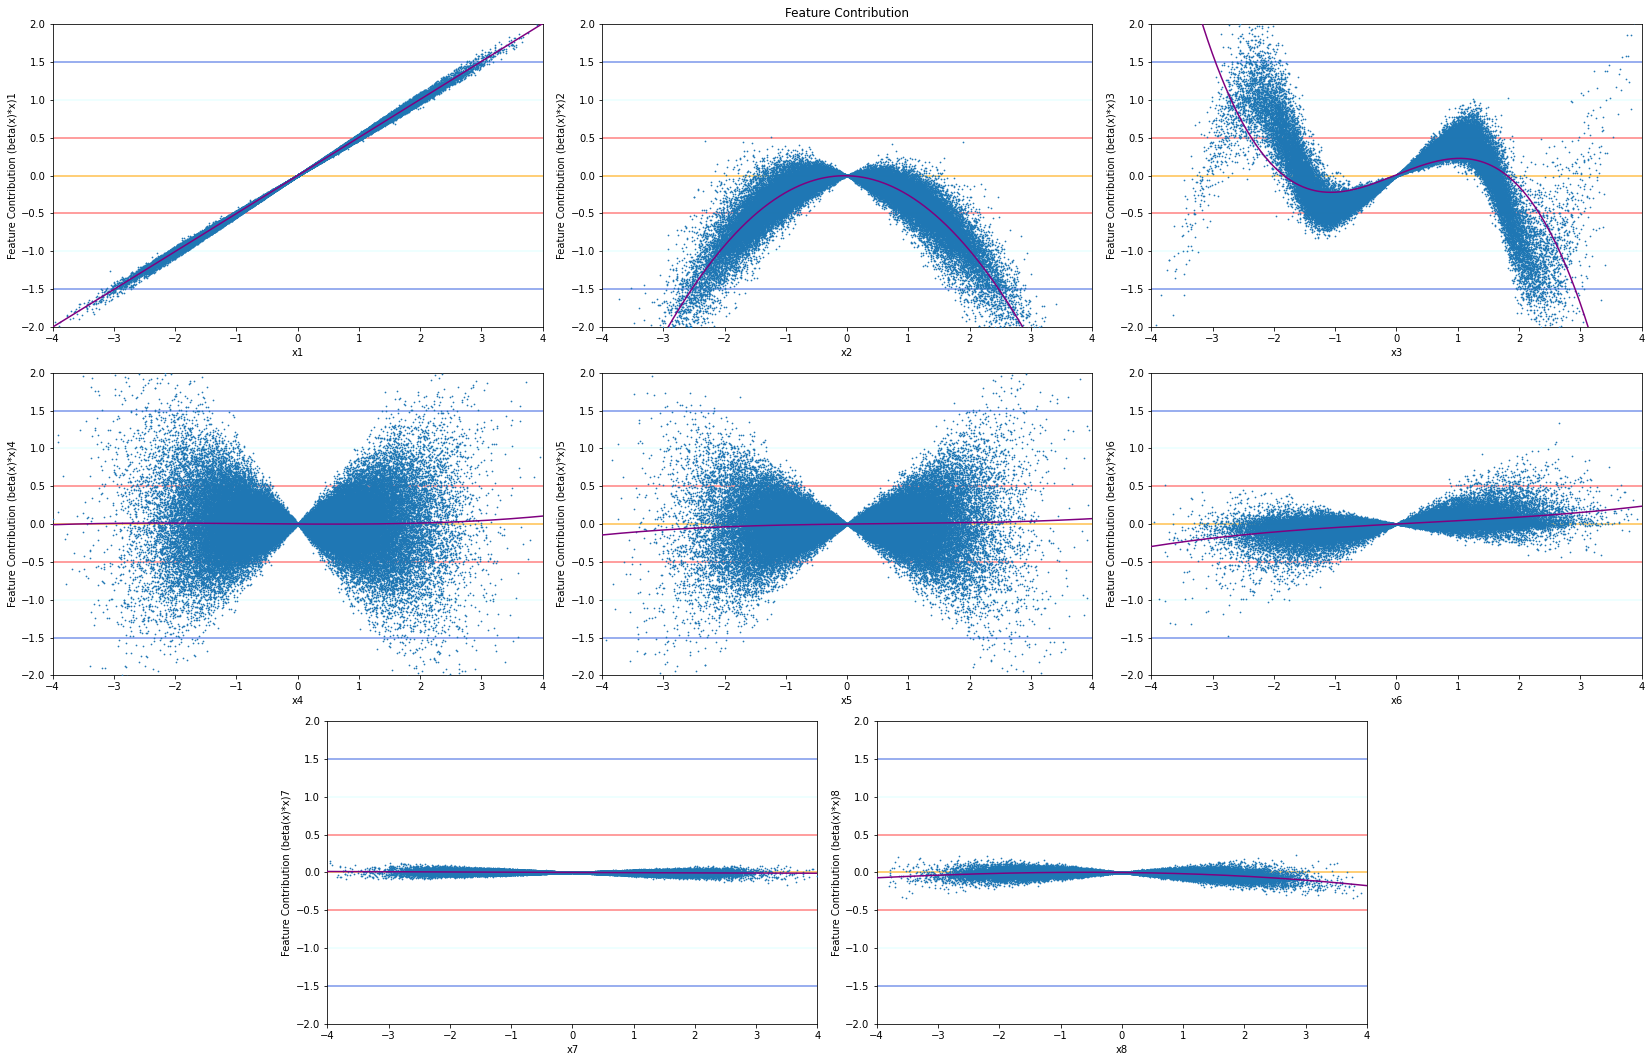

In [76]:
# Feature Contribution = beta(xi)*xi
fig_contribution = plt.figure(tight_layout=True, figsize=(30,15))

spec = GridSpec(ncols=8, nrows=3, figure=fig_contribution)
ax1_con = fig_contribution.add_subplot(spec[0, 1:3])
ax2_con = fig_contribution.add_subplot(spec[0, 3:5])
ax3_con = fig_contribution.add_subplot(spec[0, 5:7])
ax4_con = fig_contribution.add_subplot(spec[1, 1:3])
ax5_con = fig_contribution.add_subplot(spec[1, 3:5])
ax6_con = fig_contribution.add_subplot(spec[1, 5:7])
ax7_con = fig_contribution.add_subplot(spec[2, 2:4])
ax8_con = fig_contribution.add_subplot(spec[2, 4:6])

axs_con = [ax1_con, ax2_con, ax3_con, ax4_con, ax5_con, ax6_con, ax7_con, ax8_con]

xs = np.linspace(-4, 4,1000)

for i in range(len(axs_con)):

    contribution = np.column_stack([x_test[:, i], beta_x_scaled[:, i]*x_test[:, i]])
    con_ind = np.lexsort((contribution[:,1], contribution[:,0]))
    contribution_sorted = contribution[con_ind]
    con_spline = interpolate.UnivariateSpline(contribution_sorted[:,0], contribution_sorted[:,1])
    
    # Hinzufügen von horizontalen Linien um die Stärke der Feature Contribution zu visualisieren
    # Alpha --> Opacity
    # zorder --> horizontale Linien im Hintergrund/hinter eigentlichem Plot
    axs_con[i].hlines(y=0,xmin=-4,xmax=4, colors="orange",alpha=0.7,zorder=1)

    axs_con[i].hlines(y=0.5,xmin=-4,xmax=4, colors="red",alpha=0.5,zorder=1)
    axs_con[i].hlines(y=-0.5,xmin=-4,xmax=4, colors="red",alpha=0.5,zorder=1)

    axs_con[i].hlines(y=1,xmin=-4,xmax=4, colors="lightcyan",alpha=0.7,zorder=1)
    axs_con[i].hlines(y=-1,xmin=-4,xmax=4, colors="lightcyan",alpha=0.7,zorder=1)

    axs_con[i].hlines(y=1.5,xmin=-4,xmax=4, colors="royalblue",alpha=0.7,zorder=1)
    axs_con[i].hlines(y=-1.5,xmin=-4,xmax=4, colors="royalblue",alpha=0.7,zorder=1)

    # Scatter Plot --> x: Werte der Inputfeatures, y:Feature Contribution (β(x)*x)
    axs_con[i].scatter(contribution[:,0], contribution[:,1], s=0.5,zorder=10)

    axs_con[i].plot(xs,con_spline(xs), color= "purple", zorder=20)

    axs_con[i].set_xlim((-4, 4))
    axs_con[i].set_ylim((-2, 2))
    axs_con[i].set_xlabel("x"+str(i+1))
    axs_con[i].set_ylabel("Feature Contribution (beta(x)*x)"+str(i+1))

fig_contribution.suptitle("Feature Contribution")
plt.show()

## 2.3.3 Interaction Strengths <a class="anchor" id="2_3_3-bullet"></a>

In [65]:
# Extract gradients

gradients = []
x = tf.constant(x_train)

for i in range(input.shape[-1]):

    beta = attention
    beta = keras.layers.Lambda(lambda x: x[:,i])(beta)
    local_glm_net = keras.Model(inputs = input, outputs = beta)
    local_glm_net.compile(loss="mse", optimizer="nadam")

    with tf.GradientTape() as g:
        g.watch(x)
        pred_attention = local_glm_net.call(x)

    grad = g.gradient(pred_attention, x)

    # Array containing both the feature value of x aswell as the corresponding value of βk(x)
    grad_wrt_x = np.column_stack((x[:,i].numpy(), grad.numpy()))
    ind = np.lexsort((grad_wrt_x[:,2],grad_wrt_x[:,0]))
    grad_wrt_x_sorted = grad_wrt_x[ind]

    gradients.append(grad_wrt_x_sorted)

In [30]:
# Fit splines
splines = []

for i in range(input.shape[-1]):
    splines.append([])
    for j in range(input.shape[-1]):
        splines[i].append(interpolate.UnivariateSpline(gradients[i][:,0],gradients[i][:,j+1]))

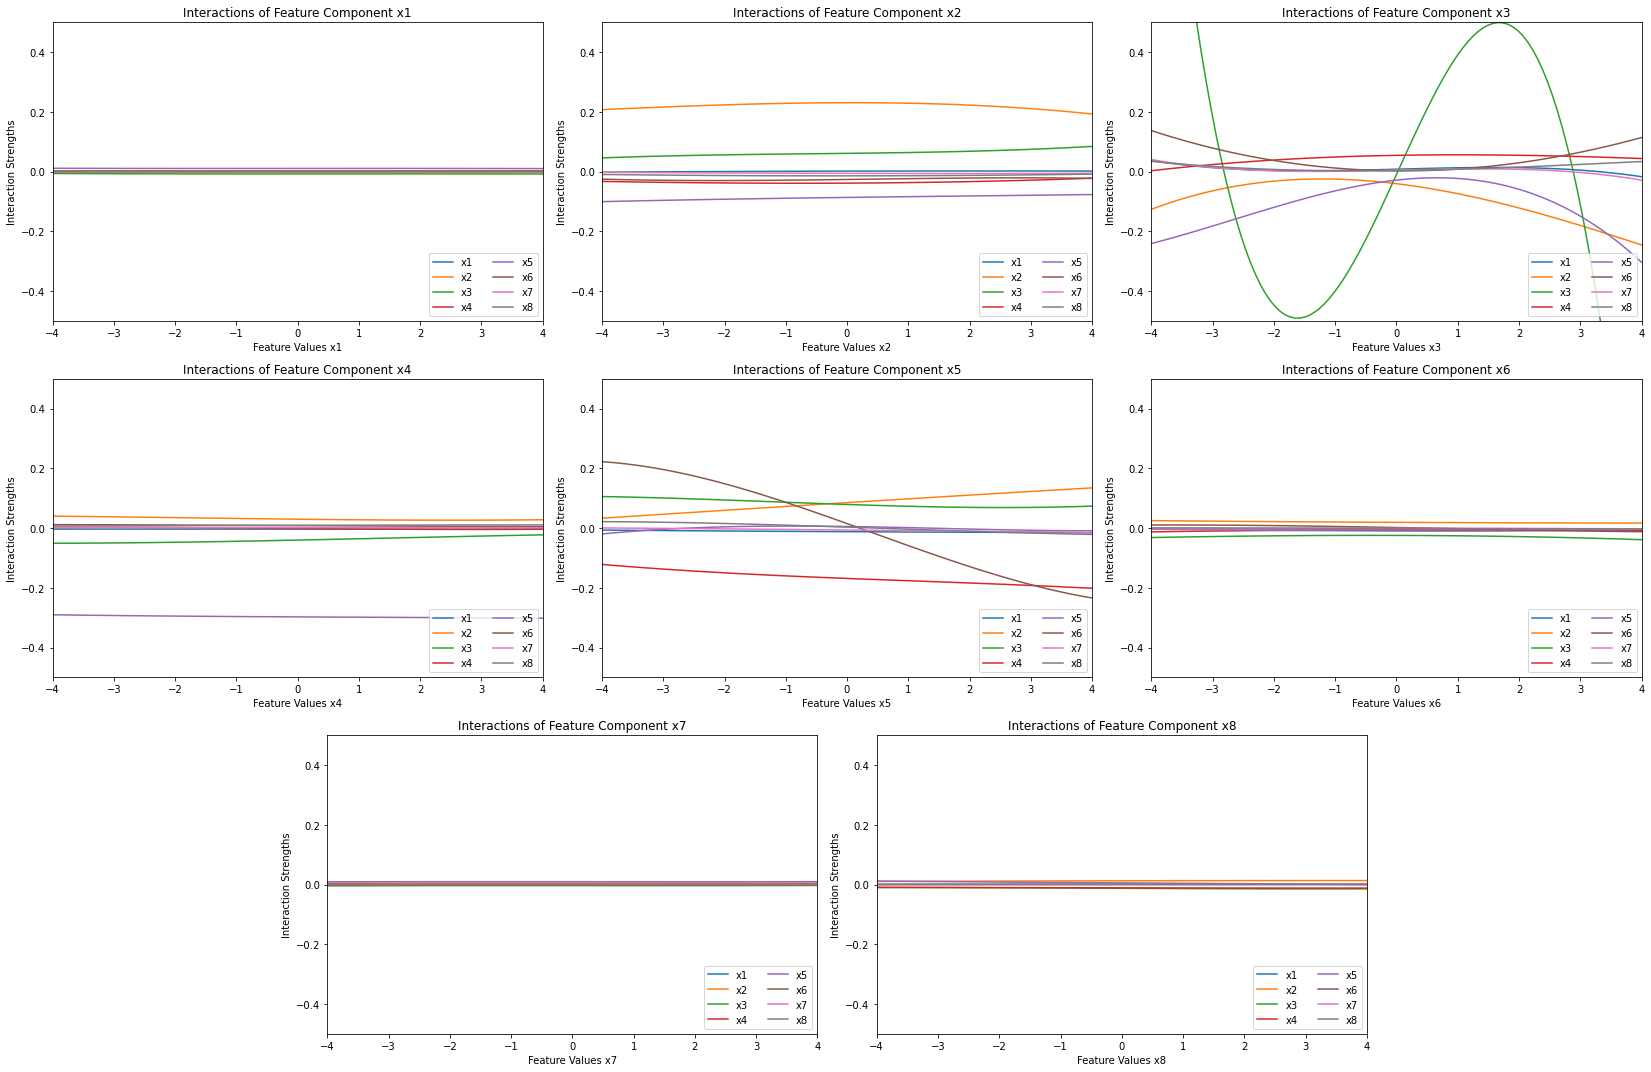

In [31]:
fig_spline = plt.figure(tight_layout=True, figsize=(30,15))
spec = GridSpec(ncols=8, nrows=3, figure=fig_spline)
ax1_sp = fig_spline.add_subplot(spec[0, 1:3])
ax2_sp = fig_spline.add_subplot(spec[0, 3:5])
ax3_sp = fig_spline.add_subplot(spec[0, 5:7])
ax4_sp = fig_spline.add_subplot(spec[1, 1:3])
ax5_sp = fig_spline.add_subplot(spec[1, 3:5])
ax6_sp = fig_spline.add_subplot(spec[1, 5:7])
ax7_sp = fig_spline.add_subplot(spec[2, 2:4])
ax8_sp = fig_spline.add_subplot(spec[2, 4:6])

axs_sp = [ax1_sp, ax2_sp, ax3_sp, ax4_sp, ax5_sp, ax6_sp, ax7_sp, ax8_sp]

xs = np.linspace(-4, 4,100)

for i in range(input.shape[-1]):
    axs_sp[i].set_xlim((-4, 4))
    axs_sp[i].set_ylim((-0.5, 0.5))
    axs_sp[i].set_xlabel("Feature Values x"+str(i+1))
    axs_sp[i].set_ylabel("Interaction Strengths")
    axs_sp[i].set_title("Interactions of Feature Component x"+str(i+1))

    for j in range(input.shape[-1]):
        axs_sp[i].plot(xs,splines[i][j](xs), label = "x"+str(j+1))
    
    axs_sp[i].legend(loc="lower right", ncol=2)

plt.show()


<hr>

# 3. Datensatz #2: freMTPL2freq <a class="anchor" id="3-bullet"></a>
<hr>

In [45]:
# french motor third party liability dataset
mtpl_df = pd.read_csv("/Users/philippknoop/Desktop/pyLocalGLMnet/data/freMTPL2freq.csv")


In [46]:
mtpl_df.head()

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1,0.10,D,5,0,55,50,B12,Regular,1217,R82
1,3.0,1,0.77,D,5,0,55,50,B12,Regular,1217,R82
2,5.0,1,0.75,B,6,2,52,50,B12,Diesel,54,R22
3,10.0,1,0.09,B,7,0,46,50,B12,Diesel,76,R72
4,11.0,1,0.84,B,7,0,46,50,B12,Diesel,76,R72


## 3.1 Preprocessing <a class="anchor" id="3_1-bullet"></a>

# 4. Zusammenfassung und Fazit <a class="anchor" id="4-bullet"></a>